In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

In [2]:
data = np.array([8, 3, 0, 8, 2, 1], dtype='int32')
dataset = tf.data.Dataset.from_tensor_slices(data)

Metal device set to: Apple M1 Pro


2022-07-24 18:00:22.070140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-24 18:00:22.070238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [4]:
for elem in dataset:
    print(elem.numpy())

8
3
0
8
2
1


In [5]:
it = iter(dataset)
print(next(it).numpy())

8


In [6]:
# reduce reduces all elements to produce a single result.
# Here it produces sum of dataset of integers.
print(dataset.reduce(0, lambda state, value: state + value).numpy())

22


2022-07-24 18:00:22.102914: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-24 18:00:22.103028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [7]:
dataset.element_spec

TensorSpec(shape=(), dtype=tf.int32, name=None)

In [8]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))
dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [9]:
dataset2 = tf.data.Dataset.from_tensor_slices(
    (
        tf.random.uniform([4, 256],),
        tf.random.uniform([4, 100], maxval=100, dtype=tf.int32),
        tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)
    )
)

In [10]:
dataset2.element_spec

(TensorSpec(shape=(256,), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [11]:
# Nested structure
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))
dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(256,), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [12]:
# Dataset containing a sparse tensor.
dataset4 = tf.data.Dataset.from_tensors(
    tf.SparseTensor(
        indices=[[0, 0], [1, 2]], # indices that contain values
        values=[1, 2], # corresponding values at indices
        dense_shape=[3, 4] # shape of the tensor
    )
)

dataset4.element_spec

SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [13]:
# Use value_type to see the type of value represented by the element spec
dataset4.element_spec.value_type

tensorflow.python.framework.sparse_tensor.SparseTensor

In [14]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32)
)
dataset1

<TensorSliceDataset element_spec=TensorSpec(shape=(10,), dtype=tf.int32, name=None)>

In [15]:
for z in dataset1:
    print(z.numpy())

[2 1 8 6 4 2 9 8 3 8]
[7 7 7 3 7 7 2 2 4 4]
[9 8 4 5 2 9 8 2 8 3]
[1 7 4 1 7 4 9 5 5 8]


In [16]:
dataset2 = tf.data.Dataset.from_tensor_slices(
    (
        tf.random.uniform([4]),
        tf.random.uniform([4, 10], maxval=100, dtype=tf.int32)
    )
)
dataset2

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.int32, name=None))>

In [17]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))
dataset3

<ZipDataset element_spec=(TensorSpec(shape=(10,), dtype=tf.int32, name=None), (TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.int32, name=None)))>

In [18]:
for a, (b, c) in dataset3:
    print('shapes: {a.shape}, {b.shape}, {c.shape}'.format(a=a, b=b, c=c))

shapes: (10,), (), (10,)
shapes: (10,), (), (10,)
shapes: (10,), (), (10,)
shapes: (10,), (), (10,)


## Reading input data

If all of the input data fits in memory, the simplest way to create a `Dataset` from them is to convert them to `tf.Tensor` objects and use `Dataset.from_tensor_slices`.

In [19]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

In [20]:
images, labels = train
images = images / 255.0

print(type(images))
print(type(labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [21]:
# Element spec does not show dim 0 which is a batch dimension
# This code will embed the features and labels arrays in TensorFlow graph
# This works well for a small dataset, but wastes memory.
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

## Consuming Python generators

In [22]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [23]:
flowers

'/Users/bcp/.keras/datasets/flower_photos'

In [24]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20
)

In [25]:
images, labels = next(img_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.


In [26]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 5)


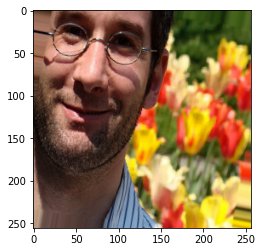

In [27]:
import matplotlib.pyplot as plt
plt.imshow(images[0])

In [28]:
ds = tf.data.Dataset.from_generator(
    lambda: img_gen.flow_from_directory(flowers),
    output_types=(tf.float32, tf.float32),
    output_shapes=([32, 256, 256, 3], [32, 5])
)

ds.element_spec

(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [29]:
for images, labels in ds.take(1):
    print(f"images.shape: {images.shape}")
    print(f"labels.shape: {labels.shape}")

Found 3670 images belonging to 5 classes.
images.shape: (32, 256, 256, 3)
labels.shape: (32, 5)


## Consuming TFRecord data

In [30]:
# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

In [31]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [32]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())
parsed.features.feature['image/text']

bytes_list {
  value: "Rue Perreyon"
}

## Consuming text data

In [33]:
directory_url = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']

file_paths = [
    tf.keras.utils.get_file(file_name, directory_url + file_name)
    for file_name in file_names
]

In [34]:
dataset = tf.data.TextLineDataset(file_paths)
dataset

<TextLineDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [35]:
for line in dataset.take(5):
    print(line.numpy())

b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b'His wrath pernicious, who ten thousand woes'
b"Caused to Achaia's host, sent many a soul"
b'Illustrious into Ades premature,'
b'And Heroes gave (so stood the will of Jove)'


In [36]:
files_ds = tf.data.Dataset.from_tensor_slices(file_paths)
lines_ds = files_ds.interleave(tf.data.TextLineDataset, cycle_length=3)

for i, line in enumerate(lines_ds.take(9)):
    if i % 3 == 0:
        print()
    print(line.numpy())


b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b"\xef\xbb\xbfOf Peleus' son, Achilles, sing, O Muse,"
b'\xef\xbb\xbfSing, O goddess, the anger of Achilles son of Peleus, that brought'

b'His wrath pernicious, who ten thousand woes'
b'The vengeance, deep and deadly; whence to Greece'
b'countless ills upon the Achaeans. Many a brave soul did it send'

b"Caused to Achaia's host, sent many a soul"
b'Unnumbered ills arose; which many a soul'
b'hurrying down to Hades, and many a hero did it yield a prey to dogs and'


In [37]:
titanic_file = tf.keras.utils.get_file(
    "train.csv", 
    "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
)
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [38]:
for line in titanic_lines.take(10):
    print(line.numpy())

b'survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone'
b'0,male,22.0,1,0,7.25,Third,unknown,Southampton,n'
b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y'
b'0,male,2.0,3,1,21.075,Third,unknown,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'


In [39]:
def survived(line):
    return tf.not_equal(tf.strings.substr(line, 0, 1), '0')

survivors = titanic_lines.skip(1).filter(survived)

In [40]:
for line in survivors.take(10):
    print(line.numpy())

b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'
b'1,male,28.0,0,0,13.0,Second,unknown,Southampton,y'
b'1,female,28.0,0,0,7.225,Third,unknown,Cherbourg,y'
b'1,male,28.0,0,0,35.5,First,A,Southampton,y'
b'1,female,38.0,1,5,31.3875,Third,unknown,Southampton,n'


## Consuming CSV data

In [41]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

In [42]:
df = pd.read_csv(titanic_file)
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


#### If data can fit into memory

In [43]:
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
    for key, value in feature_batch.items():
        print("  {!r:20s}: {}".format(key, value))

  'survived'          : 0
  'sex'               : b'male'
  'age'               : 22.0
  'n_siblings_spouses': 1
  'parch'             : 0
  'fare'              : 7.25
  'class'             : b'Third'
  'deck'              : b'unknown'
  'embark_town'       : b'Southampton'
  'alone'             : b'n'


#### Load from disk is more scalable

In [44]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name='survived'
)

In [45]:
for feature_batch, label_batch in titanic_batches.take(1):
    print(f"'survived': {label_batch}")
    print("features:")
    for key, value in feature_batch.items():
        print(f"  {key!r:20s}: {value}")

'survived': [0 1 1 1]
features:
  'sex'               : [b'male' b'male' b'female' b'male']
  'age'               : [45. 28. 36. 16.]
  'n_siblings_spouses': [0 1 0 0]
  'parch'             : [0 1 2 0]
  'fare'              : [35.5    15.2458 71.      8.05  ]
  'class'             : [b'First' b'Third' b'First' b'Third']
  'deck'              : [b'unknown' b'unknown' b'B' b'unknown']
  'embark_town'       : [b'Southampton' b'Cherbourg' b'Southampton' b'Southampton']
  'alone'             : [b'y' b'n' b'n' b'y']


In [46]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name='survived', select_columns=['class', 'fare', 'survived']
)

In [47]:
for feature_batch, label_batch in titanic_batches.take(1):
    print(f"'survived': {label_batch}")
    for key, value in feature_batch.items():
        print(f"  {key!r:20s}: {value}")

'survived': [0 0 1 1]
  'fare'              : [  5.     73.5    10.5   227.525]
  'class'             : [b'First' b'Second' b'Second' b'First']


## Consuming sets of files

In [48]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

In [49]:
flowers_root

PosixPath('/Users/bcp/.keras/datasets/flower_photos')

In [50]:
# a directory for each class
for item in flowers_root.glob('*'):
    print(item.name)

roses
sunflowers
daisy
dandelion
tulips
LICENSE.txt


In [51]:
# The files in each class directory are examples
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

In [52]:
for f in list_ds.take(5):
    print(f.numpy())

b'/Users/bcp/.keras/datasets/flower_photos/tulips/8677713853_1312f65e71.jpg'
b'/Users/bcp/.keras/datasets/flower_photos/daisy/5623010186_796ca8d29a.jpg'
b'/Users/bcp/.keras/datasets/flower_photos/sunflowers/3514340206_efb8198a80_n.jpg'
b'/Users/bcp/.keras/datasets/flower_photos/daisy/14333681205_a07c9f1752_m.jpg'
b'/Users/bcp/.keras/datasets/flower_photos/daisy/4281102584_c548a69b81_m.jpg'


In [53]:
def process_path(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

In [54]:
for image_raw, label_text in labeled_ds.take(1):
    print(repr(image_raw.numpy()[:100]))
    print()
    print(label_text.numpy())

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05'

b'tulips'


## Batching dataset elements

In [55]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
    print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]


In [56]:
# Batch size is unknown (None) because the last batch may not be full
batched_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [57]:
# Use `drop_remainder` argument to ignore that last batch, and get full shape
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<BatchDataset element_spec=(TensorSpec(shape=(7,), dtype=tf.int64, name=None), TensorSpec(shape=(7,), dtype=tf.int64, name=None))>

#### Batching tensors with padding
`Dataset.padded_batch` transformation enables you to batch tensors of different shapes.

In [58]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(2):
    print(batch.numpy())
    print()

[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



## Training workflows

In [59]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [60]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

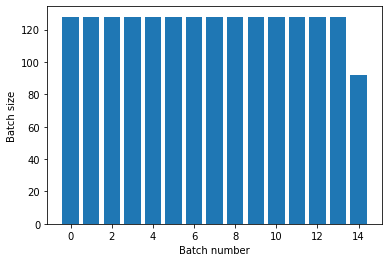

In [61]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

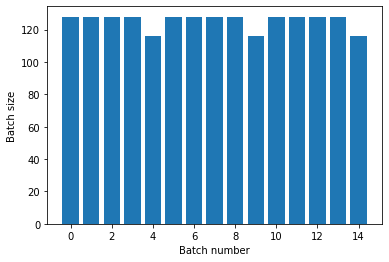

In [62]:
titanic_batches = titanic_lines.batch(128).repeat(3)
plot_batch_sizes(titanic_batches)

In [63]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
    for batch in dataset:
        print(batch.shape)
    print('End of epoch: ', epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


In [64]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [65]:
n, line_batch = next(iter(dataset))
print(n.numpy())

[ 17  72  76  51  22  29  66  10   4  52   3 104  26  45  46  83 108  18
 100   8]


##### Order matter
`.shuffle()` before `.repeat()` will show every element of one epoch before moving to the next

In [66]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
    print(n.numpy())

Here are the item ID's near the epoch boundary:

[622 627 486 623 488 612 572 508 598 615]
[332 619 590 540 626 512 580 420 524 605]
[620 616 439 522 554 499 538 548]
[ 2 13  0 98  7 54 66 95 27 37]
[ 42  65  52  75  47 105  86   6 108  44]


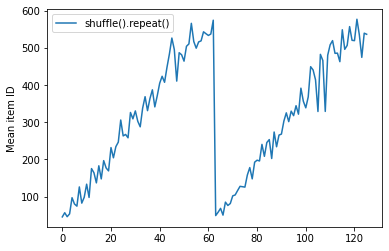

In [67]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

##### Order matter
`.repeat()` before `.shuffle()` mixes the epoch boundaries together

In [68]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[561  15  11 601 609   6  18  12 548 572]
[619  29 610  16 408  35  14 588 531 557]
[ 30 603 621  13  33 599 462 617 567 466]
[ 46 486 577  27 555  17 584 479  22 419]
[583 562  19 480  20  23 615  21  68 579]
[574  52 559 586 183 450  24 514 616  64]
[ 66 565 161 489  54 481  61  84  77  76]
[ 62  87  63 618  93 590  48  49  79  40]
[ 53 483 477 593 103 539  31 509  80  97]
[ 55 575 546  81   9 114 100 101 602 112]
[ 86  75  82  57  34  89  58 127 121 130]
[ 83   4   1 110 478  91  70 109  71 624]
[ 85 511 120  42 115   7  73 107  39  26]
[ 32 132 118 113 622 535 104 126 116 142]
[ 95 122 139 143 147  25 626 607  45 148]


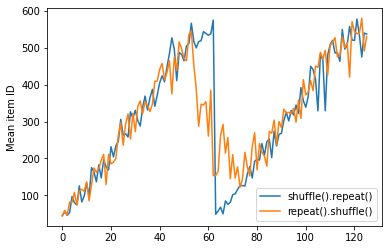

In [69]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

## Preprocessing data

The `Dataset.map(f)` transformation produces a new dataset by applying a given function `f` to each element of the input dataset.

In [70]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

In [71]:
def parse_image(filename):
    parts = tf.strings.split(filename, os.sep)
    label = parts[-2]
    
    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image, label

(128, 128, 3)


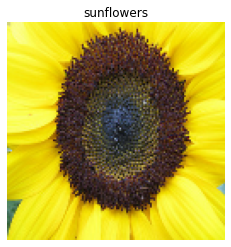

In [72]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy().decode('utf-8'))
    plt.axis('off')
    
print(image.shape)
show(image, label)

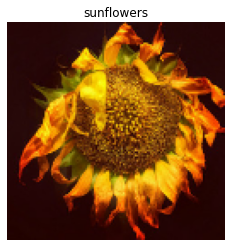

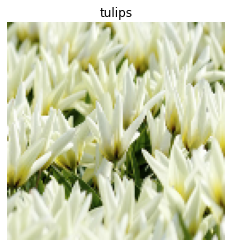

In [73]:
# Map it over dataset

images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
    show(image, label)

##### Applying arbitrary Python logic

For performance reasons, use TensorFlow operations for preprocessing your data whenever possible. However, it is sometimes useful to call external Python libraries when parsing your input data. You can use the `tf.py_function` operation in a `Dataset.map` transformation.

In [74]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
    image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


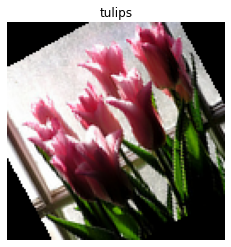

In [75]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

In [76]:
# You need to describe the return shapes and
# types when you apply the function

def tf_random_rotate_image(image, label):
    im_shape = image.shape
    [image, ] = tf.py_function(random_rotate_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


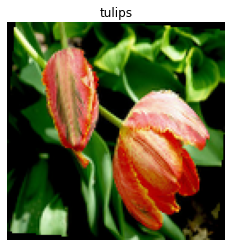

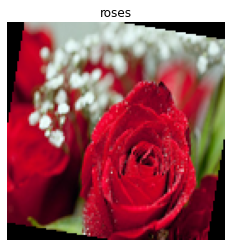

In [77]:
rotate_ds = images_ds.map(tf_random_rotate_image)

for image, label in rotate_ds.take(2):
    show(image, label)

### Parsing `tf.Example` protocol buffer messages

In [78]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

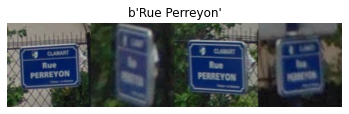

In [79]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature['image/text'].bytes_list.value[0])

In [80]:
raw_example = next(iter(dataset))

In [81]:
def tf_parse(eg):
    example = tf.io.parse_example(
        eg[tf.newaxis], 
        {
            'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
            'image/text': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
        }
    )
    return example['image/encoded'][0], example['image/text'][0]

In [82]:
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), '...')

b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [83]:
decoded = dataset.map(tf_parse)
decoded

<MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [84]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])